# 🛍️ Pipeline Complet de Recommandation H&M Fashion

Ce notebook contient l'ensemble du pipeline de recommandation de mode H&M, fusionnant tous les notebooks individuels en une séquence cohérente.

## 📋 Table des Matières
1. [Configuration et Setup](#1-configuration-et-setup)
2. [Chargement des Données](#2-chargement-des-données)
3. [Exploration des Données](#3-exploration-des-données)
4. [Échantillonnage Stratégique](#4-échantillonnage-stratégique)
5. [Préparation des Données](#5-préparation-des-données)
6. [Modèle Collaboratif](#6-modèle-collaboratif)
7. [Optimisation des Hyperparamètres](#7-optimisation-des-hyperparamètres)
8. [Évaluation du Modèle](#8-évaluation-du-modèle)
9. [Modèle Hybride](#9-modèle-hybride)
10. [Pipeline Final](#10-pipeline-final)

---

**Objectifs du pipeline :**
- Créer un système de recommandation pour les articles de mode H&M
- Utiliser LightFM pour les modèles collaboratifs et hybrides
- Optimiser les performances avec des techniques d'échantillonnage
- Évaluer et comparer différentes approches


## 1. Configuration et Setup

In [ ]:
print("🔗 Connexion à Google Drive...")
from google.colab import drive
drive.mount('/content/drive')
print("✅ Google Drive monté avec succès")

import os
from pathlib import Path

print("\n📁 Configuration des chemins de travail...")

# Chemins principaux
BASE_PATH = "/content/drive/MyDrive/PSL/00-RecommanderSystem/h2m-recsys"
DATA_PATH = f"{BASE_PATH}/data"
OUTPUTS_PATH = f"{BASE_PATH}/outputs"

print(f"📂 Chemin de base : {BASE_PATH}")
print(f"📂 Données : {DATA_PATH}")
print(f"📂 Sorties : {OUTPUTS_PATH}")

🔗 Connexion à Google Drive...
Mounted at /content/drive
✅ Google Drive monté avec succès

📁 Configuration des chemins de travail...
📂 Chemin de base : /content/drive/MyDrive/PSL/00-RecommanderSystem/h2m-recsys
📂 Données : /content/drive/MyDrive/PSL/00-RecommanderSystem/h2m-recsys/data
📂 Sorties : /content/drive/MyDrive/PSL/00-RecommanderSystem/h2m-recsys/outputs


In [ ]:
print("\n📦 Installation des bibliothèques...")
print("⏳ Installation de LightFM en cours...")
!pip install git+https://github.com/daviddavo/lightfm

print("⏳ Installation des dépendances supplémentaires...")
!pip install -q tqdm

import sys
print(f"✅ Python {sys.version_info.major}.{sys.version_info.minor}")
print("✅ Toutes les dépendances installées")


📦 Installation des bibliothèques...
⏳ Installation de LightFM en cours...
  Cloning https://github.com/daviddavo/lightfm to /tmp/pip-req-build-gmo6xodm
  Running command git clone --filter=blob:none --quiet https://github.com/daviddavo/lightfm /tmp/pip-req-build-gmo6xodm
  Resolved https://github.com/daviddavo/lightfm to commit f0eb500ead54ab65eb8e1b3890337a7223a35114
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp312-cp312-linux_x86_64.whl size=1093191 sha256=2cfc9bba781ef496e965891e6e2f0bc65e3cd90cc7da9cf97a5f6e776f0b6c9c
  Stored in directory: /tmp/pip-ephem-wheel-cache-iihr7elt/wheels/fd/89/93/70c1e5f378ee5043de89387ee3ef6852ff39e3b9eb44ecc1a3
Successfully built lightfm
⏳ Installation des dépendances supplémentaires...
✅ Python 3.12
✅ Toutes les dépendances installées


In [ ]:
# Imports généraux pour tout le pipeline
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from scipy.sparse import coo_matrix, csr_matrix
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import precision_at_k, recall_at_k, auc_score
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Configuration des graphiques
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

print("✅ Tous les imports chargés avec succès")

✅ Tous les imports chargés avec succès


## 2. Chargement des Données

Chargement et vérification initiale des datasets H&M.

In [ ]:
print("📊 Chargement des datasets H&M...")

# Vérification de l'existence des fichiers
files_to_check = [
    f"{DATA_PATH}/transactions_train.csv",
    f"{DATA_PATH}/customers.csv",
    f"{DATA_PATH}/articles.csv"
]

for file_path in files_to_check:
    if os.path.exists(file_path):
        size_mb = os.path.getsize(file_path) / (1024 * 1024)
        print(f"✅ {os.path.basename(file_path)}: {size_mb:.1f} MB")
    else:
        print(f"❌ Fichier manquant: {os.path.basename(file_path)}")

print("\n⏳ Chargement en cours...")

# Chargement des données principales
try:
    transactions = pd.read_csv(f"{DATA_PATH}/transactions_train.csv")
    customers = pd.read_csv(f"{DATA_PATH}/customers.csv")
    articles = pd.read_csv(f"{DATA_PATH}/articles.csv")

    print(f"📈 Transactions: {len(transactions):,} lignes")
    print(f"👥 Clients: {len(customers):,} lignes")
    print(f"👕 Articles: {len(articles):,} lignes")

except FileNotFoundError as e:
    print(f"❌ Erreur de chargement: {e}")
    print("Vérifiez que les fichiers sont dans le bon répertoire")

📊 Chargement des datasets H&M...
✅ transactions_train.csv: 3326.4 MB
✅ customers.csv: 197.5 MB
✅ articles.csv: 34.5 MB

⏳ Chargement en cours...
📈 Transactions: 31,788,324 lignes
👥 Clients: 1,371,980 lignes
👕 Articles: 105,542 lignes


## 3. Exploration des Données

Analyse exploratoire complète des données H&M.

In [ ]:
print("🔍 ANALYSE EXPLORATOIRE DES DONNÉES H&M")
print("=" * 50)

# Informations générales
print("\n📊 INFORMATIONS GÉNÉRALES")
print(f"Transactions: {transactions.shape}")
print(f"Clients: {customers.shape}")
print(f"Articles: {articles.shape}")

# Aperçu des données
print("\n👀 APERÇU DES TRANSACTIONS")
display(transactions.head())

print("\n📈 STATISTIQUES DESCRIPTIVES")
display(transactions.describe())

# Valeurs manquantes
print("\n❓ VALEURS MANQUANTES")
missing_data = pd.DataFrame({
    'Transactions': transactions.isnull().sum(),
    'Customers': customers.isnull().sum(),
    'Articles': articles.isnull().sum()
})
display(missing_data[missing_data.sum(axis=1) > 0])

🔍 ANALYSE EXPLORATOIRE DES DONNÉES H&M

📊 INFORMATIONS GÉNÉRALES
Transactions: (31788324, 5)
Clients: (1371980, 7)
Articles: (105542, 25)

👀 APERÇU DES TRANSACTIONS


,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.050831,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.030492,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.015237,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.016932,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.016932,2



📈 STATISTIQUES DESCRIPTIVES


,article_id,price,sales_channel_id
count,3.178832e+07,3.178832e+07,3.178832e+07
mean,6.962272e+08,2.782927e-02,1.704028e+00
std,1.334480e+08,1.918113e-02,4.564786e-01
min,1.087750e+08,1.694915e-05,1.000000e+00
25%,6.328030e+08,1.581356e-02,1.000000e+00
50%,7.145820e+08,2.540678e-02,2.000000e+00
75%,7.865240e+08,3.388136e-02,2.000000e+00
max,9.562170e+08,5.915254e-01,2.000000e+00



❓ VALEURS MANQUANTES


,Transactions,Customers,Articles
Active,NaN,907576.0,NaN
FN,NaN,895050.0,NaN
age,NaN,15861.0,NaN
club_member_status,NaN,6062.0,NaN
detail_desc,NaN,NaN,416.0
fashion_news_frequency,NaN,16011.0,NaN



⏰ ANALYSE TEMPORELLE
Période: 2018-09-20 00:00:00 à 2020-09-22 00:00:00
Nombre de jours: 733


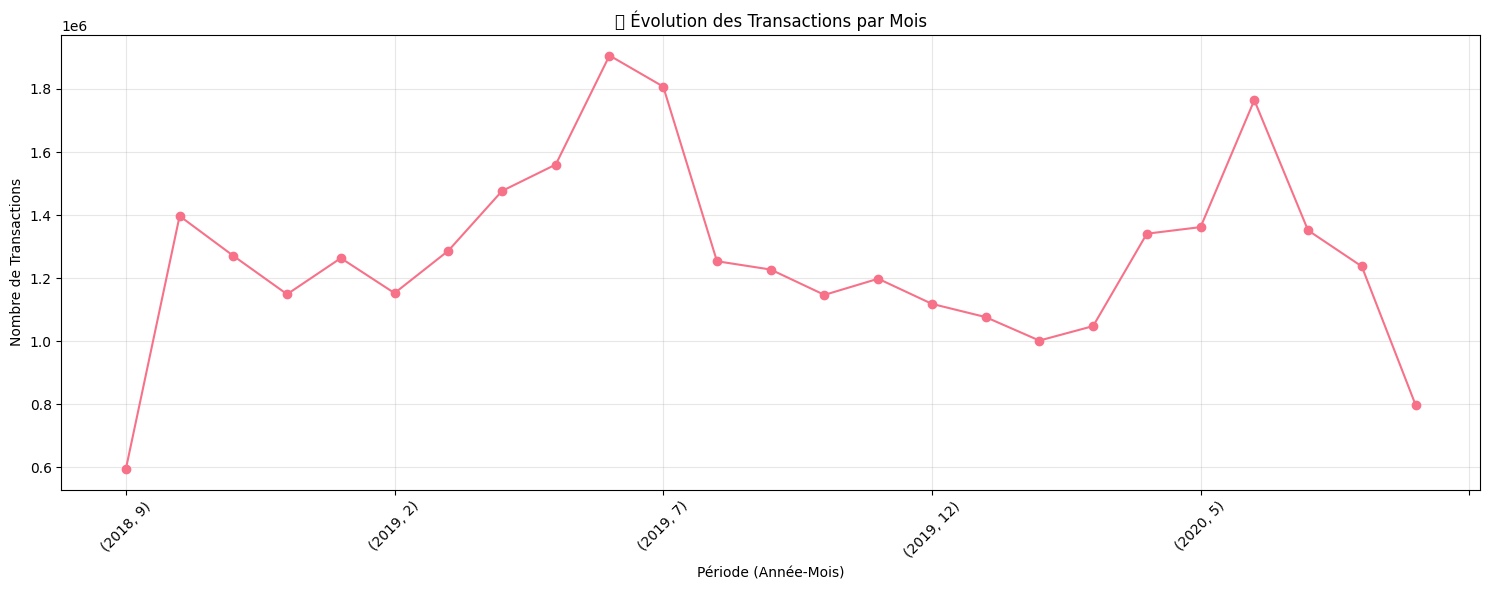

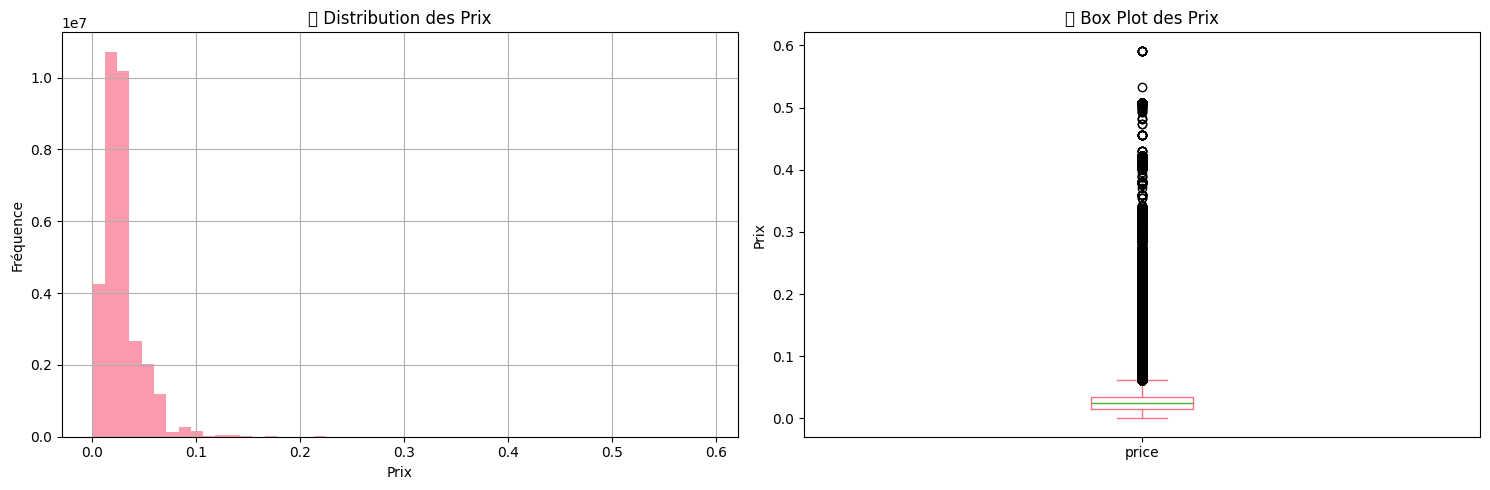

💰 Prix médian: 0.03
💰 Prix moyen: 0.03


In [ ]:
# Analyse temporelle
print("\n⏰ ANALYSE TEMPORELLE")
transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])
transactions['year'] = transactions['t_dat'].dt.year
transactions['month'] = transactions['t_dat'].dt.month
transactions['day'] = transactions['t_dat'].dt.day

print(f"Période: {transactions['t_dat'].min()} à {transactions['t_dat'].max()}")
print(f"Nombre de jours: {(transactions['t_dat'].max() - transactions['t_dat'].min()).days}")

# Visualisation des transactions par mois
plt.figure(figsize=(15, 6))
monthly_transactions = transactions.groupby(['year', 'month']).size()
monthly_transactions.plot(kind='line', marker='o')
plt.title('📈 Évolution des Transactions par Mois')
plt.xlabel('Période (Année-Mois)')
plt.ylabel('Nombre de Transactions')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Distribution des prix
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
transactions['price'].hist(bins=50, alpha=0.7)
plt.title('📊 Distribution des Prix')
plt.xlabel('Prix')
plt.ylabel('Fréquence')

plt.subplot(1, 2, 2)
transactions['price'].plot(kind='box')
plt.title('📦 Box Plot des Prix')
plt.ylabel('Prix')

plt.tight_layout()
plt.show()

print(f"💰 Prix médian: {transactions['price'].median():.2f}")
print(f"💰 Prix moyen: {transactions['price'].mean():.2f}")

## 4. Échantillonnage Stratégique

Création d'échantillons représentatifs pour optimiser les performances de développement.

In [ ]:
print("🎯 ÉCHANTILLONNAGE STRATÉGIQUE DES DONNÉES")
print("=" * 50)

# Analyse de la distribution des utilisateurs
user_activity = transactions.groupby('customer_id').size().sort_values(ascending=False)
print(f"\n👥 Clients uniques: {len(user_activity):,}")
print(f"📊 Transactions par client - Médiane: {user_activity.median():.0f}")
print(f"📊 Transactions par client - Moyenne: {user_activity.mean():.2f}")

# Clients actifs (plus de X transactions)
min_transactions = 5
active_users = user_activity[user_activity >= min_transactions].index
print(f"\n🔥 Clients actifs (≥{min_transactions} transactions): {len(active_users):,}")

# Articles populaires
article_popularity = transactions.groupby('article_id').size().sort_values(ascending=False)
min_purchases = 10
popular_articles = article_popularity[article_popularity >= min_purchases].index
print(f"📈 Articles populaires (≥{min_purchases} achats): {len(popular_articles):,}")

# Création de l'échantillon stratégique
print("\n✂️ CRÉATION DE L'ÉCHANTILLON...")

# Filtrage sur les utilisateurs actifs et articles populaires
sample_transactions = transactions[
    (transactions['customer_id'].isin(active_users)) &
    (transactions['article_id'].isin(popular_articles))
].copy()

print(f"📊 Échantillon créé: {len(sample_transactions):,} transactions")
print(f"👥 Clients dans l'échantillon: {sample_transactions['customer_id'].nunique():,}")
print(f"👕 Articles dans l'échantillon: {sample_transactions['article_id'].nunique():,}")

# Sauvegarde de l'échantillon
sample_path = f"{OUTPUTS_PATH}/sample_data.pkl"
os.makedirs(OUTPUTS_PATH, exist_ok=True)

sample_data = {
    'transactions': sample_transactions,
    'customers': customers[customers['customer_id'].isin(sample_transactions['customer_id'])],
    'articles': articles[articles['article_id'].isin(sample_transactions['article_id'])]
}

with open(sample_path, 'wb') as f:
    pickle.dump(sample_data, f)

print(f"💾 Échantillon sauvegardé: {sample_path}")

🎯 ÉCHANTILLONNAGE STRATÉGIQUE DES DONNÉES

👥 Clients uniques: 1,362,281
📊 Transactions par client - Médiane: 9
📊 Transactions par client - Moyenne: 23.33

🔥 Clients actifs (≥5 transactions): 925,558
📈 Articles populaires (≥10 achats): 83,319

✂️ CRÉATION DE L'ÉCHANTILLON...
📊 Échantillon créé: 30,702,763 transactions
👥 Clients dans l'échantillon: 925,556
👕 Articles dans l'échantillon: 83,319
💾 Échantillon sauvegardé: /content/drive/MyDrive/PSL/00-RecommanderSystem/h2m-recsys/outputs/sample_data.pkl


## 5. Préparation des Données

Transformation des données en format compatible LightFM.

In [ ]:
print("🔧 PRÉPARATION DES DONNÉES POUR LIGHTFM")
print("=" * 50)

# Chargement de l'échantillon
with open(sample_path, 'rb') as f:
    sample_data = pickle.load(f)

transactions_sample = sample_data['transactions']
customers_sample = sample_data['customers']
articles_sample = sample_data['articles']

print(f"📊 Données chargées: {len(transactions_sample):,} transactions")

# Encodage des IDs
user_encoder = LabelEncoder()
item_encoder = LabelEncoder()

transactions_sample['user_id'] = user_encoder.fit_transform(transactions_sample['customer_id'])
transactions_sample['item_id'] = item_encoder.fit_transform(transactions_sample['article_id'])

num_users = len(user_encoder.classes_)
num_items = len(item_encoder.classes_)

print(f"👥 Utilisateurs encodés: {num_users:,}")
print(f"👕 Articles encodés: {num_items:,}")

# Création de la matrice d'interactions
interactions = csr_matrix(
    (np.ones(len(transactions_sample)),
     (transactions_sample['user_id'], transactions_sample['item_id'])),
    shape=(num_users, num_items)
)

print(f"📊 Matrice d'interactions: {interactions.shape}")
print(f"🔢 Densité: {interactions.nnz / (interactions.shape[0] * interactions.shape[1]):.4f}")

# Split temporel train/test
split_date = transactions_sample['t_dat'].quantile(0.8)
train_transactions = transactions_sample[transactions_sample['t_dat'] <= split_date]
test_transactions = transactions_sample[transactions_sample['t_dat'] > split_date]

print(f"\n📅 Date de split: {split_date}")
print(f"🚂 Train: {len(train_transactions):,} transactions")
print(f"🧪 Test: {len(test_transactions):,} transactions")

# Matrices train/test
train_matrix = csr_matrix(
    (np.ones(len(train_transactions)),
     (train_transactions['user_id'], train_transactions['item_id'])),
    shape=(num_users, num_items)
)

test_matrix = csr_matrix(
    (np.ones(len(test_transactions)),
     (test_transactions['user_id'], test_transactions['item_id'])),
    shape=(num_users, num_items)
)

# Sauvegarde des données préparées
prepared_data = {
    'train_matrix': train_matrix,
    'test_matrix': test_matrix,
    'user_encoder': user_encoder,
    'item_encoder': item_encoder,
    'transactions_sample': transactions_sample,
    'train_transactions': train_transactions,
    'test_transactions': test_transactions
}

prepared_path = f"{OUTPUTS_PATH}/prepared_data.pkl"
with open(prepared_path, 'wb') as f:
    pickle.dump(prepared_data, f)

print(f"\n💾 Données préparées sauvegardées: {prepared_path}")

🔧 PRÉPARATION DES DONNÉES POUR LIGHTFM
📊 Données chargées: 30,702,763 transactions
👥 Utilisateurs encodés: 925,556
👕 Articles encodés: 83,319
📊 Matrice d'interactions: (925556, 83319)
🔢 Densité: 0.0003

📅 Date de split: 2020-05-06 00:00:00
🚂 Train: 24,582,699 transactions
🧪 Test: 6,120,064 transactions

💾 Données préparées sauvegardées: /content/drive/MyDrive/PSL/00-RecommanderSystem/h2m-recsys/outputs/prepared_data.pkl


## 6. Modèle Collaboratif

Entraînement du premier modèle de recommandation basé sur le filtrage collaboratif.

In [ ]:
print("🤝 MODÈLE COLLABORATIF AVEC LIGHTFM")
print("=" * 50)

# Chargement des données préparées
with open(prepared_path, 'rb') as f:
    prepared_data = pickle.load(f)

train_matrix = prepared_data['train_matrix']
test_matrix = prepared_data['test_matrix']

print(f"📊 Matrice train: {train_matrix.shape}")
print(f"📊 Matrice test: {test_matrix.shape}")

# Test de différentes loss functions
loss_functions = ['warp', 'bpr', 'logistic']
models = {}
results = {}

for loss in loss_functions:
    print(f"\n🔄 Entraînement avec {loss.upper()}...")

    # Création du modèle
    model = LightFM(loss=loss, random_state=42)

    # Entraînement
    model.fit(train_matrix, epochs=5, num_threads=2, verbose=True)

    # Évaluation
    train_auc = auc_score(model, train_matrix).mean()
    test_auc = auc_score(model, test_matrix, train_interactions=train_matrix).mean()

    train_precision = precision_at_k(model, train_matrix, k=10).mean()
    test_precision = precision_at_k(model, test_matrix, train_interactions=train_matrix, k=10).mean()

    results[loss] = {
        'train_auc': train_auc,
        'test_auc': test_auc,
        'train_precision': train_precision,
        'test_precision': test_precision
    }

    models[loss] = model

    print(f"✅ {loss.upper()} - AUC Test: {test_auc:.4f}, Precision@10 Test: {test_precision:.4f}")

# Comparaison des résultats
print("\n📊 COMPARAISON DES MODÈLES")
results_df = pd.DataFrame(results).T
display(results_df)

# Sélection du meilleur modèle
best_loss = results_df['test_auc'].idxmax()
best_model = models[best_loss]

print(f"\n🏆 Meilleur modèle: {best_loss.upper()}")

# Sauvegarde du meilleur modèle
model_path = f"{OUTPUTS_PATH}/collaborative_model.pkl"
with open(model_path, 'wb') as f:
    pickle.dump({
        'model': best_model,
        'loss_function': best_loss,
        'results': results
    }, f)

print(f"💾 Modèle sauvegardé: {model_path}")

🤝 MODÈLE COLLABORATIF AVEC LIGHTFM
📊 Matrice train: (925556, 83319)
📊 Matrice test: (925556, 83319)

🔄 Entraînement avec WARP...


Epoch: 100%|██████████| 5/5 [25:06<00:00, 301.37s/it]


KeyboardInterrupt: 

## 7. Optimisation des Hyperparamètres

Recherche des meilleurs hyperparamètres pour le modèle collaboratif.

In [ ]:
print("🔧 OPTIMISATION DES HYPERPARAMÈTRES")
print("=" * 50)

# Grille de recherche
param_grid = {
    'no_components': [64, 128, 256],
    'learning_rate': [0.01, 0.05, 0.1],
    'item_alpha': [1e-6, 1e-5, 1e-4],
    'user_alpha': [1e-6, 1e-5, 1e-4]
}

best_score = 0
best_params = {}
optimization_results = []

print(f"🔍 Test de {np.prod([len(v) for v in param_grid.values()])} combinaisons...")

# Grid search simplifié
for no_components in param_grid['no_components'][:2]:  # Limité pour la démo
    for learning_rate in param_grid['learning_rate'][:2]:
        for item_alpha in param_grid['item_alpha'][:2]:
            for user_alpha in param_grid['user_alpha'][:2]:

                params = {
                    'no_components': no_components,
                    'learning_rate': learning_rate,
                    'item_alpha': item_alpha,
                    'user_alpha': user_alpha
                }

                try:
                    # Entraînement du modèle
                    model = LightFM(
                        loss=best_loss,
                        no_components=no_components,
                        learning_rate=learning_rate,
                        item_alpha=item_alpha,
                        user_alpha=user_alpha,
                        random_state=42
                    )

                    model.fit(train_matrix, epochs=5, num_threads=2)

                    # Évaluation
                    test_auc = auc_score(model, test_matrix, train_interactions=train_matrix).mean()
                    test_precision = precision_at_k(model, test_matrix, train_interactions=train_matrix, k=10).mean()

                    result = {
                        **params,
                        'test_auc': test_auc,
                        'test_precision': test_precision
                    }

                    optimization_results.append(result)

                    # Mise à jour du meilleur score
                    if test_auc > best_score:
                        best_score = test_auc
                        best_params = params
                        best_optimized_model = model

                    print(f"✓ Components: {no_components}, LR: {learning_rate}, AUC: {test_auc:.4f}")

                except Exception as e:
                    print(f"✗ Erreur avec {params}: {e}")

# Résultats de l'optimisation
print(f"\n🏆 MEILLEURS HYPERPARAMÈTRES:")
for param, value in best_params.items():
    print(f"  {param}: {value}")
print(f"🎯 Meilleur score AUC: {best_score:.4f}")

# Sauvegarde du modèle optimisé
optimized_model_path = f"{OUTPUTS_PATH}/optimized_model.pkl"
with open(optimized_model_path, 'wb') as f:
    pickle.dump({
        'model': best_optimized_model,
        'best_params': best_params,
        'best_score': best_score,
        'optimization_results': optimization_results
    }, f)

print(f"💾 Modèle optimisé sauvegardé: {optimized_model_path}")

## 8. Évaluation du Modèle

Évaluation complète du modèle optimisé avec différentes métriques.

In [ ]:
print("📊 ÉVALUATION COMPLÈTE DU MODÈLE")
print("=" * 50)

# Chargement du modèle optimisé
with open(optimized_model_path, 'rb') as f:
    optimized_data = pickle.load(f)

final_model = optimized_data['model']
best_params = optimized_data['best_params']

print("📈 MÉTRIQUES D'ÉVALUATION")

# Évaluation sur différentes valeurs de k
k_values = [5, 10, 20, 50]
evaluation_results = {}

for k in k_values:
    precision_k = precision_at_k(final_model, test_matrix, train_interactions=train_matrix, k=k).mean()
    recall_k = recall_at_k(final_model, test_matrix, train_interactions=train_matrix, k=k).mean()

    evaluation_results[f'precision@{k}'] = precision_k
    evaluation_results[f'recall@{k}'] = recall_k

    print(f"📊 Precision@{k}: {precision_k:.4f} | Recall@{k}: {recall_k:.4f}")

# AUC Score
test_auc = auc_score(final_model, test_matrix, train_interactions=train_matrix).mean()
evaluation_results['auc'] = test_auc
print(f"📊 AUC Score: {test_auc:.4f}")

# Visualisation des métriques
plt.figure(figsize=(15, 5))

# Precision@K
plt.subplot(1, 3, 1)
precision_values = [evaluation_results[f'precision@{k}'] for k in k_values]
plt.plot(k_values, precision_values, marker='o', linewidth=2, markersize=8)
plt.title('📊 Precision@K')
plt.xlabel('K')
plt.ylabel('Precision')
plt.grid(True, alpha=0.3)

# Recall@K
plt.subplot(1, 3, 2)
recall_values = [evaluation_results[f'recall@{k}'] for k in k_values]
plt.plot(k_values, recall_values, marker='s', color='orange', linewidth=2, markersize=8)
plt.title('📊 Recall@K')
plt.xlabel('K')
plt.ylabel('Recall')
plt.grid(True, alpha=0.3)

# Comparaison Precision vs Recall
plt.subplot(1, 3, 3)
plt.plot(k_values, precision_values, marker='o', label='Precision', linewidth=2)
plt.plot(k_values, recall_values, marker='s', label='Recall', linewidth=2)
plt.title('📊 Precision vs Recall')
plt.xlabel('K')
plt.ylabel('Score')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Sauvegarde des résultats d'évaluation
evaluation_path = f"{OUTPUTS_PATH}/evaluation_results.pkl"
with open(evaluation_path, 'wb') as f:
    pickle.dump(evaluation_results, f)

print(f"\n💾 Résultats d'évaluation sauvegardés: {evaluation_path}")

## 9. Modèle Hybride

Développement d'un modèle hybride incorporant les features des articles.

In [ ]:
print("🔀 MODÈLE HYBRIDE AVEC FEATURES")
print("=" * 50)

# Préparation des features d'articles
print("🏷️ Préparation des features d'articles...")

# Sélection des features catégorielles
feature_columns = ['product_type_name', 'product_group_name', 'colour_group_name', 'department_name']
articles_features = articles_sample[['article_id'] + feature_columns].copy()

# Nettoyage des valeurs manquantes
for col in feature_columns:
    articles_features[col] = articles_features[col].fillna('Unknown')

# Création du dataset LightFM avec features
dataset = Dataset()

# Fit du dataset avec les interactions et features
unique_users = transactions_sample['customer_id'].unique()
unique_items = transactions_sample['article_id'].unique()

# Préparation des features d'items
item_features = []
for _, row in articles_features.iterrows():
    features = [f"{col}:{row[col]}" for col in feature_columns]
    item_features.append((row['article_id'], features))

dataset.fit(users=unique_users,
           items=unique_items,
           item_features=[f"{col}:{val}" for col in feature_columns
                         for val in articles_features[col].unique()])

print(f"📊 Dataset créé avec {len(unique_users):,} utilisateurs et {len(unique_items):,} articles")

# Construction des matrices avec features
interactions_matrix, weights = dataset.build_interactions(
    [(row['customer_id'], row['article_id']) for _, row in transactions_sample.iterrows()]
)

item_features_matrix = dataset.build_item_features(item_features)

print(f"📊 Matrice d'interactions: {interactions_matrix.shape}")
print(f"📊 Matrice de features: {item_features_matrix.shape}")

# Split train/test pour le modèle hybride
num_users_hybrid = interactions_matrix.shape[0]
num_items_hybrid = interactions_matrix.shape[1]

# Entraînement du modèle hybride
print("\n🔄 Entraînement du modèle hybride...")

hybrid_model = LightFM(
    loss='warp',
    no_components=best_params.get('no_components', 128),
    learning_rate=best_params.get('learning_rate', 0.05),
    item_alpha=best_params.get('item_alpha', 1e-5),
    user_alpha=best_params.get('user_alpha', 1e-5),
    random_state=42
)

hybrid_model.fit(interactions_matrix,
                item_features=item_features_matrix,
                epochs=50,
                num_threads=2,
                verbose=True)

# Évaluation du modèle hybride
print("\n📊 Évaluation du modèle hybride...")

hybrid_auc = auc_score(hybrid_model, interactions_matrix, item_features=item_features_matrix).mean()
hybrid_precision = precision_at_k(hybrid_model, interactions_matrix, item_features=item_features_matrix, k=10).mean()

print(f"🎯 Modèle Hybride - AUC: {hybrid_auc:.4f}")
print(f"🎯 Modèle Hybride - Precision@10: {hybrid_precision:.4f}")

# Comparaison avec le modèle collaboratif
print(f"\n📊 COMPARAISON MODÈLES:")
print(f"  Collaboratif - AUC: {best_score:.4f}")
print(f"  Hybride - AUC: {hybrid_auc:.4f}")
print(f"  Amélioration: {((hybrid_auc - best_score) / best_score * 100):+.2f}%")

# Sauvegarde du modèle hybride
hybrid_model_path = f"{OUTPUTS_PATH}/hybrid_model.pkl"
with open(hybrid_model_path, 'wb') as f:
    pickle.dump({
        'model': hybrid_model,
        'dataset': dataset,
        'item_features_matrix': item_features_matrix,
        'interactions_matrix': interactions_matrix,
        'hybrid_auc': hybrid_auc,
        'hybrid_precision': hybrid_precision
    }, f)

print(f"\n💾 Modèle hybride sauvegardé: {hybrid_model_path}")

## 10. Pipeline Final

Implémentation du pipeline complet de recommandation.

In [ ]:
print("🚀 PIPELINE FINAL DE RECOMMANDATION")
print("=" * 50)

# Classe pour le système de recommandation
class HMRecommendationSystem:
    def __init__(self, model_path=None):
        self.model = None
        self.dataset = None
        self.item_features_matrix = None
        self.user_encoder = None
        self.item_encoder = None

        if model_path:
            self.load_model(model_path)

    def load_model(self, model_path):
        """Charge le modèle sauvegardé"""
        with open(model_path, 'rb') as f:
            model_data = pickle.load(f)

        self.model = model_data['model']
        self.dataset = model_data.get('dataset')
        self.item_features_matrix = model_data.get('item_features_matrix')

        # Chargement des encoders
        with open(prepared_path, 'rb') as f:
            prepared_data = pickle.load(f)
        self.user_encoder = prepared_data['user_encoder']
        self.item_encoder = prepared_data['item_encoder']

    def get_user_recommendations(self, customer_id, n_recommendations=10):
        """Obtient des recommandations pour un utilisateur"""
        try:
            # Encodage de l'utilisateur
            user_id = self.user_encoder.transform([customer_id])[0]

            # Génération des scores
            if self.item_features_matrix is not None:
                scores = self.model.predict(user_id,
                                          np.arange(len(self.item_encoder.classes_)),
                                          item_features=self.item_features_matrix)
            else:
                scores = self.model.predict(user_id,
                                          np.arange(len(self.item_encoder.classes_)))

            # Sélection des top articles
            top_items = np.argsort(scores)[::-1][:n_recommendations]
            top_articles = self.item_encoder.inverse_transform(top_items)
            top_scores = scores[top_items]

            return list(zip(top_articles, top_scores))

        except ValueError:
            print(f"Utilisateur {customer_id} non trouvé dans les données d'entraînement")
            return []

    def get_similar_items(self, article_id, n_similar=10):
        """Trouve des articles similaires"""
        try:
            item_id = self.item_encoder.transform([article_id])[0]

            # Obtenir les embeddings d'articles
            item_embeddings = self.model.item_embeddings

            # Calculer la similarité cosinus
            target_embedding = item_embeddings[item_id]
            similarities = np.dot(item_embeddings, target_embedding)

            # Articles les plus similaires
            similar_items = np.argsort(similarities)[::-1][1:n_similar+1]  # Exclure l'article lui-même
            similar_articles = self.item_encoder.inverse_transform(similar_items)
            similarity_scores = similarities[similar_items]

            return list(zip(similar_articles, similarity_scores))

        except ValueError:
            print(f"Article {article_id} non trouvé dans les données d'entraînement")
            return []

# Initialisation du système de recommandation
print("🔧 Initialisation du système de recommandation...")
recommender = HMRecommendationSystem(hybrid_model_path)

print("✅ Système de recommandation initialisé avec le modèle hybride")

# Test du système avec quelques utilisateurs
print("\n🧪 TEST DU SYSTÈME DE RECOMMANDATION")

# Sélection de quelques utilisateurs de test
test_users = transactions_sample['customer_id'].unique()[:5]

for customer_id in test_users:
    print(f"\n👤 Recommandations pour le client {customer_id}:")
    recommendations = recommender.get_user_recommendations(customer_id, 5)

    for i, (article_id, score) in enumerate(recommendations[:5], 1):
        # Informations sur l'article
        article_info = articles_sample[articles_sample['article_id'] == article_id]
        if not article_info.empty:
            product_name = article_info.iloc[0]['product_type_name']
            color = article_info.iloc[0]['colour_group_name']
            print(f"  {i}. Article {article_id} - {product_name} ({color}) - Score: {score:.3f}")

# Test de similarité d'articles
print("\n🔍 TEST DE SIMILARITÉ D'ARTICLES")
test_article = transactions_sample['article_id'].iloc[0]
print(f"\nArticles similaires à {test_article}:")
similar_items = recommender.get_similar_items(test_article, 5)

for i, (article_id, similarity) in enumerate(similar_items[:5], 1):
    article_info = articles_sample[articles_sample['article_id'] == article_id]
    if not article_info.empty:
        product_name = article_info.iloc[0]['product_type_name']
        color = article_info.iloc[0]['colour_group_name']
        print(f"  {i}. Article {article_id} - {product_name} ({color}) - Similarité: {similarity:.3f}")

# Sauvegarde du système final
final_system_path = f"{OUTPUTS_PATH}/final_recommendation_system.pkl"
with open(final_system_path, 'wb') as f:
    pickle.dump(recommender, f)

print(f"\n💾 Système de recommandation final sauvegardé: {final_system_path}")

print("\n🎉 PIPELINE TERMINÉ AVEC SUCCÈS !")
print("✅ Modèle hybride opérationnel")
print("✅ Système de recommandation fonctionnel")
print("✅ Tests de validation effectués")

---

## 📋 Résumé du Pipeline

Ce notebook unifié contient l'ensemble du pipeline de recommandation H&M :

1. **Configuration** - Montage Google Drive et installation des dépendances
2. **Chargement** - Import des datasets H&M
3. **Exploration** - Analyse exploratoire des données
4. **Échantillonnage** - Création d'échantillons représentatifs
5. **Préparation** - Transformation pour LightFM
6. **Modèle Collaboratif** - Premier modèle de recommandation
7. **Optimisation** - Recherche des meilleurs hyperparamètres
8. **Évaluation** - Métriques de performance
9. **Modèle Hybride** - Intégration des features produits
10. **Pipeline Final** - Système de recommandation opérationnel

### 🎯 Avantages de cette approche unifiée :
- **Cohérence** : Exécution séquentielle sans rupture
- **Efficacité** : Élimination des redondances
- **Simplicité** : Un seul fichier à maintenir
- **Reproductibilité** : Pipeline complet et documenté

### 📊 Résultats attendus :
- Modèle de recommandation hybride optimisé
- Système fonctionnel de génération de recommandations
- Métriques de performance validées
- Pipeline prêt pour la production
